In [1]:
import cv2
import matplotlib as plt
import numpy
import matplotlib.pyplot as plt
from collections import Counter
import torch

from torchvision import datasets, transforms


(1294, 630, 3)
(1294, 630)


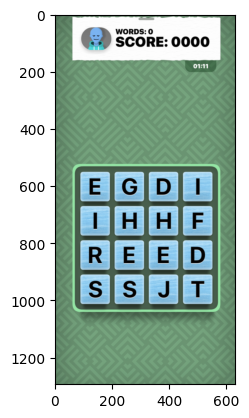

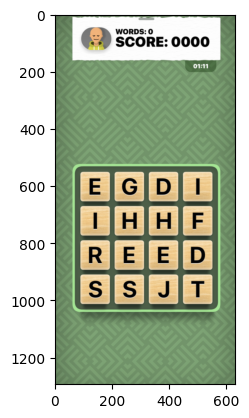

In [2]:

board = r"C:\Users\craha\Downloads\board2.png"
image = cv2.imread(board)
print(image.shape)
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(grayImage.shape)
plt.imshow(image)
plt.show()

rgbImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgbImage)
plt.show()

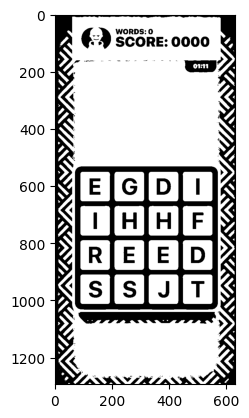

In [3]:
ret, bnwImage = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
plt.imshow(bnwImage, cmap='gray')
plt.show()

In [4]:
contours, hierarchy = cv2.findContours(bnwImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)


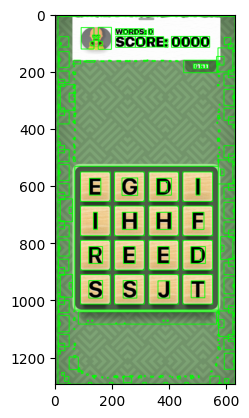

In [5]:
import cv2
debug_image = image.copy()

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(debug_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
plt.show()


In [6]:
tile_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if 90 <= w <= 120 and 90 <= h <= 120:
        tile_boxes.append((x, y, w, h))
tile_boxes = sorted(tile_boxes, key=lambda b: (round(b[1]/100), b[0]))


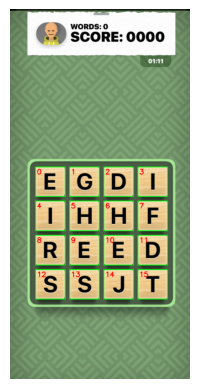

In [7]:
debug_image = image.copy()
for idx, (x, y, w, h) in enumerate(tile_boxes):
    cv2.rectangle(debug_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(debug_image, str(idx), (x + 5, y + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [8]:
for x, y, w, h in tile_boxes:
    print(f"x: {x}, y: {y}, w: {w}, h: {h}")
nTile_boxes = []

for x, y, w, h in tile_boxes:
    #crop
    tile = image[y:y+h, x:x+w]

    #gray
    gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)

    #resize
    resized = cv2.resize(gray, (64, 64))

    #convert
    tensor = transforms.ToTensor()(resized).unsqueeze(0)

    nTile_boxes.append(tensor)

x: 89, y: 552, w: 104, h: 103
x: 208, y: 552, w: 104, h: 103
x: 328, y: 552, w: 104, h: 103
x: 447, y: 552, w: 104, h: 103
x: 89, y: 671, w: 104, h: 104
x: 208, y: 671, w: 104, h: 104
x: 328, y: 671, w: 104, h: 104
x: 447, y: 671, w: 104, h: 104
x: 89, y: 791, w: 104, h: 104
x: 208, y: 791, w: 104, h: 104
x: 328, y: 791, w: 104, h: 104
x: 447, y: 791, w: 104, h: 104
x: 89, y: 911, w: 104, h: 103
x: 208, y: 911, w: 104, h: 103
x: 328, y: 911, w: 104, h: 103
x: 447, y: 911, w: 104, h: 103


In [9]:
print(nTile_boxes[1])

tensor([[[[0.3333, 0.3373, 0.4000,  ..., 0.4275, 0.3412, 0.3373],
          [0.3373, 0.3961, 0.7412,  ..., 0.7843, 0.4863, 0.3412],
          [0.3725, 0.7412, 0.8980,  ..., 0.9020, 0.7882, 0.4235],
          ...,
          [0.3412, 0.7373, 0.8471,  ..., 0.8510, 0.7765, 0.3961],
          [0.3098, 0.3686, 0.7608,  ..., 0.7961, 0.4902, 0.3137],
          [0.3137, 0.3059, 0.3922,  ..., 0.4392, 0.3176, 0.3176]]]])


In [10]:
from myOcr.model import TileCNN

model = TileCNN()  
model.load_state_dict(torch.load("myOcr/tile_cnn.pth"))
model.eval()


TileCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24, bias=True)
)

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder("myOcr/tiles_dataset", transform=transform)
idx_to_class = dataset.classes

boardTest = []
for tile in nTile_boxes:
    output = model(tile)
    pred_idx = torch.argmax(output, dim=1).item()
    boardTest.append(pred_idx)

idx_to_class = dataset.classes  

for i in range(0, 16, 4):
    row = boardTest[i:i+4]
    letters = [idx_to_class[idx] for idx in row]
    print(" ".join(letters))


E G D I
I H H F
R E E D
S S J T


In [16]:
tile_data = []

for idx, (x, y, w, h) in enumerate(tile_boxes):
    letter_idx = boardTest[idx]
    letter = idx_to_class[letter_idx]

    center_x = x + w // 2
    center_y = y + h // 2

    tile_data.append((letter, (center_x, center_y)))
    
with open("tile_data.txt", "w") as f:
    for letter, (x, y) in tile_data:
        f.write(f"{letter} {x} {y}\n")
